In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [7]:

# Функция загрузки данных Dogecoin
def get_doge_data():
    doge = yf.Ticker("DOGE-USD")
    df = doge.history(period="7d", interval="1m")  # Данные за 7 дней с шагом 1 минута
    df.reset_index(inplace=True)

    # Добавляем временные признаки
    df["hour"] = df["Datetime"].dt.hour
    df["minute"] = df["Datetime"].dt.minute
    df["dayofweek"] = df["Datetime"].dt.dayofweek

    # Добавляем лаговые признаки
    df["Close_lag1"] = df["Close"].shift(1)
    df["Close_lag5"] = df["Close"].shift(5)
    df["Close_lag10"] = df["Close"].shift(10)

    return df.dropna()  # Убираем строки с NaN

In [8]:
# Загружаем и обрабатываем данные
data = get_doge_data()
data.set_index('Datetime', inplace=True)

# Выбираем признаки и целевую переменную
features = ["Open", "High", "Low", "Volume", "hour", "minute", "dayofweek", "Close_lag1", "Close_lag5", "Close_lag10"]
target = "Close"

X = data[features]
y = data[target]

# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [9]:
# Функция обновления модели и прогнозирования
def predict_future_prices():
    global model, X_train, y_train

    # Загружаем новые данные
    new_data = get_doge_data()
    new_data.set_index('Datetime', inplace=True)

    # Объединяем старые и новые данные
    combined_data = pd.concat([data, new_data]).drop_duplicates()
    X_train, y_train = combined_data[features], combined_data[target]

    # Дообучаем модель
    model.fit(X_train, y_train)

    # Прогнозируем цену через разные интервалы
    last_row = pd.DataFrame([new_data.iloc[-1][features]], columns=features)

    future_times = [10]  # Минуты (10 минут, 1 час, 6 часов)
    prediction_results = []

    for future_time in future_times:
        future_index = new_data.index[-1] + pd.Timedelta(minutes=future_time)

        # Модифицируем временные признаки для будущего времени
        last_row["hour"] = future_index.hour
        last_row["minute"] = future_index.minute
        last_row["dayofweek"] = future_index.dayofweek

        predicted_price = model.predict(last_row)[0]
        prediction_results.append((future_index, predicted_price))
        print(f"Через {future_time} минут ({future_index}): {predicted_price:.5f} USD")

    # Построение графика
    plot_predictions(new_data, prediction_results)




Через 10 минут (2025-03-20 16:16:00+00:00): 0.16993 USD


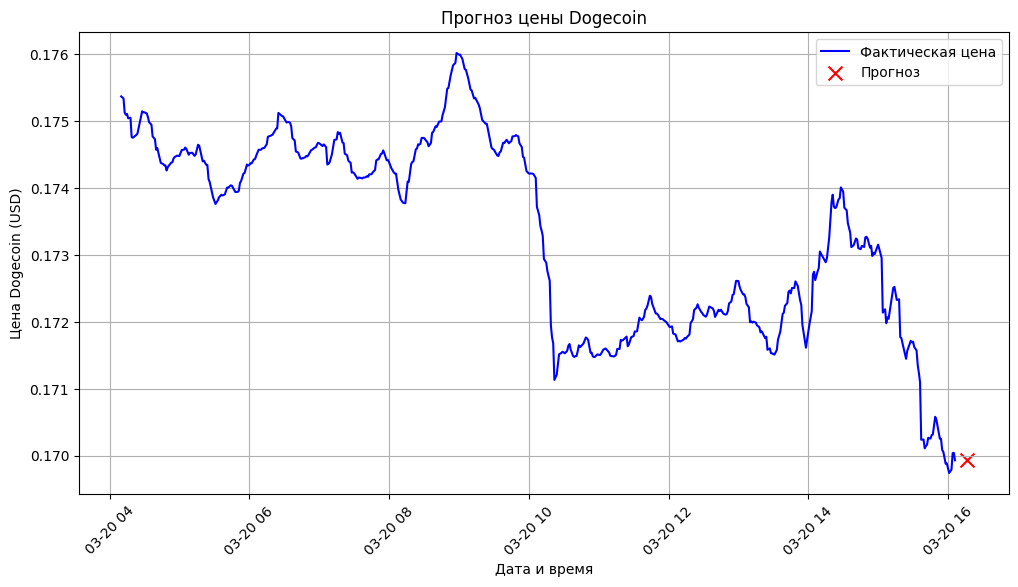

In [10]:
# Функция построения графика
def plot_predictions(data, prediction_results):
    plt.figure(figsize=(12, 6))

    # График фактических цен
    plt.plot(data.index[-500:], data["Close"].tail(500), label="Фактическая цена", color="blue")

    # Предсказанные значения
    times, prices = zip(*prediction_results)
    plt.scatter(times, prices, color="red", label="Прогноз", marker="x", s=100)

    plt.xlabel("Дата и время")
    plt.ylabel("Цена Dogecoin (USD)")
    plt.title("Прогноз цены Dogecoin")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Выполняем прогноз
predict_future_prices()